In [149]:
import requests
import dill as pickle
import pandas as pd
from bs4 import BeautifulSoup
from random import randint
import time
import numpy as np
from datetime import datetime
from datetime import *
from sklearn.cross_validation import train_test_split
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [2]:
'''
actor_movie_table
The following function generates a list of lists consisting of the first table found on a particular
actor's boxofficemojo page

The movie_attribute protion of the code loops through the html table, capturing everything until the
table list generated by beautifulsoup ends

all_movies is the list of lists containing all movies found on the table on the actor's page
'''

def actor_movie_table(actor_page, all_movie_html_block):
    movie_table = []
    all_movies = []
    for x in range(1, len(all_movie_html_block)):
        movie_html_block = all_movie_html_block[x]
        movie_items = []
        for i in range(0, len(movie_html_block.find_all('td'))):
            movie_attribute = movie_html_block.find_all('td')[i].text
            movie_items.append(movie_attribute)
            try:
                movie_html = movie_html_block.find_all('td')[i].a['href']
            except:
                movie_html = ""
            #attribute_info = [movie_attribute, movie_html]
            movie_items.append(movie_html)
        movie_table.append(movie_items+[actor_page])
    all_movies = all_movies + movie_table
    return all_movies

In [3]:
'''
actor_page_loop loops through all actors on a list to capture their list of movies using the
actor_movie_table function

all_movies retrieves a list of lists consisting of all the movies found on all the actor's pages
'''

def actor_page_loop(actor_list):
    all_movies = []
    for row in actor_list:
        url = row[1]
        response = requests.get(url)
        while response.status_code != 200:
            if response.status_code == 403:
                break
            print "Waiting for webpage to respond"
            print url
            time.sleep(randint(1,10))
        page = response.text
        soup = BeautifulSoup(page)
        actor_page = row[0]
        try:
            movie_desc_block = soup.find_all('table')[1].find_all('tr')[0].find_all('td')[0].find_all('tr')
            movie_list = actor_movie_table(actor_page, movie_desc_block)
        except:
            movie_list = [['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']]
        all_movies = all_movies + movie_list
    return all_movies

In [4]:
def movie_desc_table(movie_name, all_movie_html_block):
    movie_table = []
    movie_html_block = []
    movie_attribute = []
    movie_items = []
    movie = []
    contributor_desc = ""
    for x in range(len(all_movie_html_block)): #len(all_movie_html_block)
        movie_items = [] #this is cleared out as we reloop through the list to append new individual movie attributes
        movie_html_block = all_movie_html_block[x] #individual blocks from all_movie_html_block
        movie = movie_name
        for i in range(1, len(movie_html_block.find_all('a'))):
            movie_role = movie_html_block.find_all('a')[0].text
            name = movie_html_block.find_all('a')[i].text
            try:
                movie_html = movie_html_block.find_all('a')[i]['href']
            except:
                movie_html = ""
            movie_items =[movie, name, movie_role, movie_html] #movie_role, 
            movie_table.append(movie_items)
    return movie_table

In [5]:
def movie_page_loop(loop_df):
    nc_movies = []
    for row in loop_df:
        url = row
        response = requests.get(url)
        while response.status_code != 200:
            if response.status_code == 403:
                break
            print "Waiting for webpage to respond"
            print url
            time.sleep(randint(1,10))
        page = response.text
        soup = BeautifulSoup(page)
        #Sets the block that we are looking at that contains the contributors for the film
        try:
            movie_name = soup.find_all('b')[1].text
            movie_desc_block = soup.find(text = 'The Players').parent.parent.find_all('table')[0].find_all('tr')
            movie = movie_desc_table(movie_name, movie_desc_block)
        except:
            movie = [["","","",""]]
        nc_movies.append(movie)
    return nc_movies

In [6]:
'''
Nicolas Cage's page is the following: http://www.boxofficemojo.com/people/chart/?id=nicolascage.htm
'''

url = 'http://www.boxofficemojo.com/people/chart/?id=nicolascage.htm'
response = requests.get(url)
response.status_code

with open('nc_webpage.pkl', 'w') as picklefile:
    pickle.dump(response, picklefile)

with open("nc_webpage.pkl", 'r') as picklefile: 
    response = pickle.load(picklefile)

In [7]:
page = response.text
soup = BeautifulSoup(page)
all_movie_html_block_1 = soup.find_all('table')[1].find_all('tr')[0].find_all('td')[0].find_all('tr')
all_movie_html_block_2 = soup.find_all('table')[3].find_all('tr')
movie_table1 = actor_movie_table('Nicolas Cage', all_movie_html_block_1)
movie_table2 = actor_movie_table('Nicolas Cage', all_movie_html_block_2)
col = ['date', 'date_url', 'movie', 'movie_url', 'studio', 'studio_url', 'gross', 'gross_url', 'theaters_g', 'theaters_g_url', 'opening', 'opening_url', 'theaters_o', 'theaters_o_url', 'rank', 'rank_url','name']
nc_movies_1 = pd.DataFrame(movie_table1, columns = col)
nc_movies_1['date_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['date_url']
nc_movies_1['movie_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['movie_url']
nc_movies_1['studio_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['studio_url']
nc_movies_1['gross_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['gross_url']
nc_movies_1['theaters_g_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['theaters_g_url']
nc_movies_1['opening_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['opening_url']
nc_movies_1['theaters_o_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['theaters_o_url']
nc_movies_1['rank_url'] = 'http://www.boxofficemojo.com/'+nc_movies_1['rank_url']

In [8]:
'''
Loop through Nicolas Cage movies to find people who have worked with him
'''

loop_df = nc_movies_1['movie_url'].values
nc_colab = movie_page_loop(loop_df)


In [9]:
'''
Only grab actors who have worked with Nicolas Cage
'''

nc_actors = []
actor_stuff = []
for row in nc_colab:
    for movie, name, role, url in row:
        if role == u'Actors:':
            if url == "":
                url = ""
            else:
                url = "http://www.boxofficemojo.com"+url
            actor_stuff = [movie, name, role, url]
            nc_actors.append(actor_stuff)


In [10]:
'''
Manipulate output list to create a new list to loop through to find out more information about actors that
have worked with Nicolas Cage
'''

loop_df = []
for row in nc_actors:
    name = row[1].replace('*','')
    url =  row[3]
    loop_df.append([name,url])

loop_dict = {}
for row in loop_df:
    loop_dict[row[0]] = row[1]

unique_loop = []
for actor in loop_dict:
    unique_loop.append([actor, loop_dict[actor]])

In [11]:
'''
Create dataset of movies of actors that have worked with Nicolas Cage
'''

all_actor_movies = actor_page_loop(unique_loop)

col = ['date', 'date_url', 'movie', 'movie_url', 'studio', 'studio_url', 'gross', 'gross_url', 'theaters_g', 'theaters_g_url', 'opening', 'opening_url', 'theaters_o', 'theaters_o_url', 'rank', 'rank_url','name']
all_actor_movies_df = pd.DataFrame(all_actor_movies, columns = col)
all_actor_movies_df['date_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['date_url']
all_actor_movies_df['movie_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['movie_url']
all_actor_movies_df['studio_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['studio_url']
all_actor_movies_df['gross_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['gross_url']
all_actor_movies_df['theaters_g_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['theaters_g_url']
all_actor_movies_df['opening_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['opening_url']
all_actor_movies_df['theaters_o_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['theaters_o_url']
all_actor_movies_df['rank_url'] = 'http://www.boxofficemojo.com'+all_actor_movies_df['rank_url']

loop_df = all_actor_movies_df['movie_url'].values
movies_df_nonnc = movie_page_loop(loop_df)

In [12]:
new_table = []
for row in movies_df_nonnc:
    for x in row:
        new_table.append(x)

list_1 = []
list_2 = []
for row in new_table:
    if type(row) == type([]):
        list_1.append(row)
    else:
        list_2.append(row)

col = ['movie', 'name', 'role', 'url']
all_movies_df = pd.DataFrame(list_1, columns = col)
all_movies_df['url'] = 'http://www.boxofficemojo.com'+all_movies_df['url']

In [13]:
all_actors = []
actor_stuff = []
for movie, name, role, url in new_table:
    if role == u'Actors:':
        if url == "":
            url = ""
        else:
            url = "http://www.boxofficemojo.com"+url
            actor_stuff = [movie, name, role, url]
            all_actors.append(actor_stuff)

In [14]:
all_actors_loop = []
for movie, name, role, url in all_actors:
    name = name.replace('*','')
    url =  url
    all_actors_loop.append([name,url])

all_actors_dict = {}
for row in all_actors_loop:
    all_actors_dict[row[0]] = row[1]

unique_all_actors = []
for actor in all_actors_dict:
    unique_all_actors.append([actor, all_actors_dict[actor]])
    
comp_actor_movies = actor_page_loop(unique_all_actors)

In [15]:
col = ['date', 'date_url', 'movie', 'movie_url', 'studio', 'studio_url', 'gross', 'gross_url', 'theaters_g', 'theaters_g_url', 'opening', 'opening_url', 'theaters_o', 'theaters_o_url', 'rank', 'rank_url','name']
comp_actor_df = pd.DataFrame(comp_actor_movies, columns = col)
comp_actor_df['date'] = comp_actor_df['date'].apply(pd.to_datetime) 
comp_actor_df = comp_actor_df[comp_actor_df.date != 'N/A']
comp_actor_df['gross'] = (comp_actor_df['gross'].replace('[\$,)]','', regex=True).replace( '[(]','-', regex=True ).convert_objects(convert_numeric=True).astype(float))
comp_actor_df['name'] = comp_actor_df['name'].str.replace('*', '')
calc_comp_actor_df = comp_actor_df[['name','movie','date','gross']]

In [105]:
def date_loop(date_list, date_range):
    df_final = pd.DataFrame()
    for date in date_list:
        date_before_bound = relevant_dates[relevant_dates.date < date]#.sort('date', ascending = False)
        date_before = date_before_bound[date_before_bound.date > date-timedelta(days = date_range)].sort('date', ascending = False)
        date_after_bound = relevant_dates[relevant_dates.date > date].sort('date', ascending = False)
        date_after = date_after_bound[date_after_bound.date < date + timedelta(days = date_range)].sort('date', ascending = False)
        groupby_before = date_before.groupby('name')#.mean('gross')
        date_before_count = groupby_before.count(['movie']).reset_index()
        date_before_sum = groupby_before.sum().reset_index()
        date_before_mean = groupby_before.mean().reset_index()
        col = ['name', 'before_movie_count', 'before_total_gross', 'before_mean_gross']
        date_before_summary = pd.DataFrame(columns = col)
        date_before_summary['name'] = date_before_count['name']
        date_before_summary['before_movie_count'] = date_before_count['movie']
        date_before_summary['before_total_gross'] = date_before_sum['gross']
        date_before_summary['before_mean_gross'] = date_before_mean['gross']
        date_before_summary['date'] = date
        groupby_after = date_after.groupby('name')#.mean('gross')
        date_after_count = groupby_after.count(['movie']).reset_index()
        date_after_sum = groupby_after.sum().reset_index()
        date_after_mean = groupby_after.mean().reset_index()
        col = ['name', 'after_movie_count', 'after_total_gross', 'after_mean_gross']
        date_after_summary = pd.DataFrame(columns = col)
        date_after_summary['name'] = date_after_count['name']
        date_after_summary['after_movie_count'] = date_after_count['movie']
        date_after_summary['after_total_gross'] = date_after_sum['gross']
        date_after_summary['after_mean_gross'] = date_after_mean['gross']
        date_after_summary['date'] = date
        date_summary = pd.merge(left=date_before_summary, right=date_after_summary, how='outer', on = ['name', 'date'])
        #col = ['name', 'date', 'before_movie_count', 'before_total_gross', 'before_mean_gross', 'after_movie_count', 'after_total_gross', 'after_mean_gross']
        #df_final = date_summary
        #print date_summary.head()
        df_final = df_final.append(date_summary, ignore_index = True)
        #print df_final.head()
    df_final = df_final.dropna()
    return df_final

In [106]:
date_boundry_upper = calc_comp_actor_df[calc_comp_actor_df.date < datetime(2016,1,1)].sort('date', ascending = False)
relevant_dates = date_boundry_upper[date_boundry_upper.date > datetime(1970,1,1)].sort('date', ascending = True)
relevant_dates

comparison_nc_df = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
comparison_nc_df = comparison_nc_df[['movie', 'date']].reset_index()
comparison_nc_df = comparison_nc_df[['movie', 'date']]
compare_frame_test = comparison_nc_df['movie'].tolist()
comparison_actor_df = calc_comp_actor_df
comparison_actor_df['nc_movie'] = comparison_actor_df[['movie']].isin(compare_frame_test)
comparison_actor_df[comparison_actor_df['nc_movie'] == True]
## This is a frame of actors, movies, and dates where they were in movies with Nicolas Cage
nc_actor_frame = comparison_actor_df[comparison_actor_df['nc_movie'] == True]
nc_actor_list = nc_actor_frame[['name','date']]
actor_list = nc_actor_list['name'].tolist()
date_list = nc_actor_list['date'].tolist()
zip_list = zip(actor_list, date_list)

nc_dates = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
nc_dates_list = nc_dates['date'].tolist()
analysis_frame = date_loop(nc_dates_list, 300)
analysis_frame = analysis_frame.dropna()
analysis_frame.head()

analysis_frame2 = analysis_frame
analysis_frame2['name_date'] = zip(analysis_frame['name'], analysis_frame['date'])
analysis_frame2['nc_movies'] = analysis_frame.name_date.apply(lambda x: x in zip_list)
analysis_frame2[analysis_frame2['nc_movies'] == True]
analysis_frame2.head()


/Users/johnwalters/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,before_movie_count,before_total_gross,before_mean_gross,date,after_movie_count,after_total_gross,after_mean_gross,name_date,nc_movies
1,Aaron Johnson,1,200676069,200676069,2014-10-03,1,458991599,458991599.0,"(Aaron Johnson, 2014-10-03 00:00:00)",False
3,Abigail Breslin,1,37738810,37738810,2014-10-03,1,187112,187112.0,"(Abigail Breslin, 2014-10-03 00:00:00)",False
4,Adam Sandler,2,47000518,23500259,2014-10-03,1,77885284,77885284.0,"(Adam Sandler, 2014-10-03 00:00:00)",False
5,Adam Scott,1,58236838,58236838,2014-10-03,2,13425173,6712586.5,"(Adam Scott, 2014-10-03 00:00:00)",False
10,Amanda Crew,1,2827666,2827666,2014-10-03,1,42629776,42629776.0,"(Amanda Crew, 2014-10-03 00:00:00)",False


In [75]:
comparison_nc_df = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
comparison_nc_df = comparison_nc_df[['movie', 'date']].reset_index()
comparison_nc_df = comparison_nc_df[['movie', 'date']]
compare_frame_test = comparison_nc_df['movie'].tolist()
comparison_actor_df = calc_comp_actor_df
comparison_actor_df['nc_movie'] = comparison_actor_df[['movie']].isin(compare_frame_test)
comparison_actor_df[comparison_actor_df['nc_movie'] == True]
## This is a frame of actors, movies, and dates where they were in movies with Nicolas Cage
nc_actor_frame = comparison_actor_df[comparison_actor_df['nc_movie'] == True]
nc_actor_list = nc_actor_frame[['name','date']]
actor_list = nc_actor_list['name'].tolist()
date_list = nc_actor_list['date'].tolist()
zip_list = zip(actor_list, date_list)
analysis_frame2 = analysis_frame
analysis_frame2['name_date'] = zip(analysis_frame['name'], analysis_frame['date'])
analysis_frame2['nc_movies'] = analysis_frame.name_date.apply(lambda x: x in zip_list)
analysis_frame2[analysis_frame2['nc_movies'] == True]
analysis_frame2.head()

/Users/johnwalters/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,name,before_movie_count,before_total_gross,before_mean_gross,date,after_movie_count,after_total_gross,after_mean_gross,name_date,nc_movies
0,50 Cent,1,25135965,2.513596e+07,2014-10-03,2,163115604,81557802.0,"(50 Cent, 2014-10-03 00:00:00)",False
2,Aaron Johnson,2,229472054,1.147360e+08,2014-10-03,1,458991599,458991599.0,"(Aaron Johnson, 2014-10-03 00:00:00)",False
4,Abigail Breslin,3,151348379,5.044946e+07,2014-10-03,1,187112,187112.0,"(Abigail Breslin, 2014-10-03 00:00:00)",False
5,Adam Brody,2,21926091,1.096305e+07,2014-10-03,1,8265,8265.0,"(Adam Brody, 2014-10-03 00:00:00)",False
6,Adam Sandler,3,180669043,6.022301e+07,2014-10-03,2,173104599,86552299.5,"(Adam Sandler, 2014-10-03 00:00:00)",False


In [57]:
y, X = dmatrices('after_mean_gross ~ before_mean_gross + nc_movies', data=analysis_frame2, return_type='dataframe')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [59]:
model = sm.OLS(y_train, X_train)
results = model.fit()

In [60]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       after_mean_gross   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     589.4
Date:                Thu, 08 Oct 2015   Prob (F-statistic):          9.53e-247
Time:                        21:32:42   Log-Likelihood:            -2.7783e+05
No. Observations:               14372   AIC:                         5.557e+05
Df Residuals:                   14369   BIC:                         5.557e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          3.937e+07   6.71e+05     58.697      0.000      3.81e+07  4.07e+07
nc_movies[T.True] -3.497e+06   5.63e+06     -0.621      0.535     -1.45e+07  7.54e+06
before_mean_gross     0.2922      0.009     34.322      0.000         0.276     0.309
==============================================================================
Omnibus:                     7825.184   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            83796.637
Skew:                           2.415   Prob(JB):                         0.00
Kurtosis:                      13.799   Cond. No.                     8.82e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.82e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1136cc650>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x112191510>]], dtype=object)

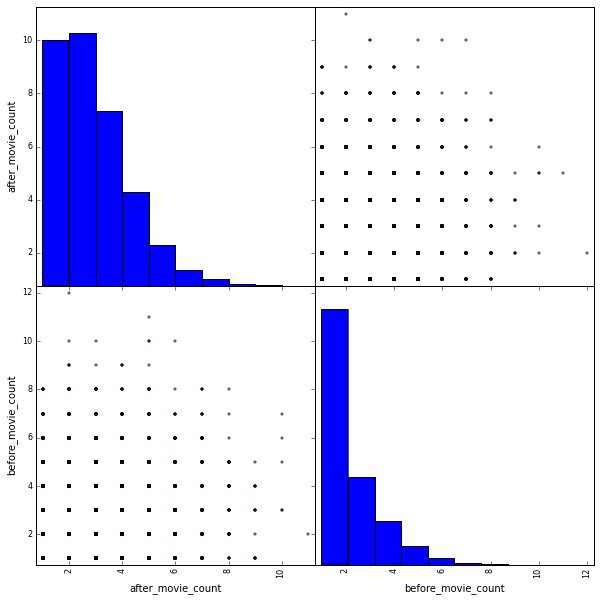

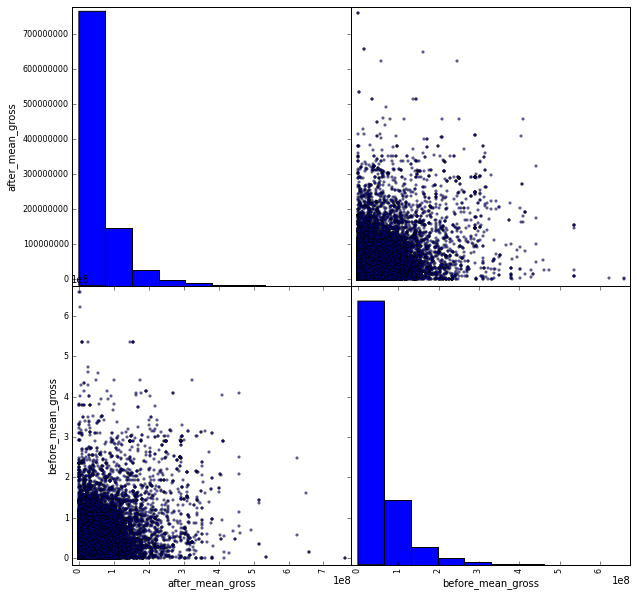

In [69]:
%matplotlib inline
cols = ['after_movie_count', 'before_movie_count']
pd.scatter_matrix(analysis_frame2[cols], figsize=(10, 10))
cols = ['after_mean_gross', 'before_mean_gross']
pd.scatter_matrix(analysis_frame2[cols], figsize=(10, 10))

In [88]:
count_list = range(1,6)

def analysis_loop(count_list):
    frame_list = []
    nc_dates = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
    nc_dates_list = nc_dates['date'].tolist()
    for x in count_list:
        date_range = x*300
        analysis_frame = date_loop(nc_dates_list, date_range)
        comparison_nc_df = calc_comp_actor_df[calc_comp_actor_df['name'] == 'Nicolas Cage']
        comparison_nc_df = comparison_nc_df[['movie', 'date']].reset_index()
        comparison_nc_df = comparison_nc_df[['movie', 'date']]
        compare_frame_test = comparison_nc_df['movie'].tolist()
        comparison_actor_df = calc_comp_actor_df
        comparison_actor_df['nc_movie'] = comparison_actor_df[['movie']].isin(compare_frame_test)
        comparison_actor_df[comparison_actor_df['nc_movie'] == True]
        ## This is a frame of actors, movies, and dates where they were in movies with Nicolas Cage
        nc_actor_frame = comparison_actor_df[comparison_actor_df['nc_movie'] == True]
        nc_actor_list = nc_actor_frame[['name','date']]
        actor_list = nc_actor_list['name'].tolist()
        date_list = nc_actor_list['date'].tolist()
        zip_list = zip(actor_list, date_list)
        analysis_frame['name_date'] = zip(analysis_frame['name'], analysis_frame['date'])
        analysis_frame['nc_movies'] = analysis_frame.name_date.apply(lambda x: x in zip_list)
        frame_list.append(analysis_frame)
    return frame_list

In [100]:
count_list = range(1,11)
all_models = analysis_loop(count_list)

/Users/johnwalters/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


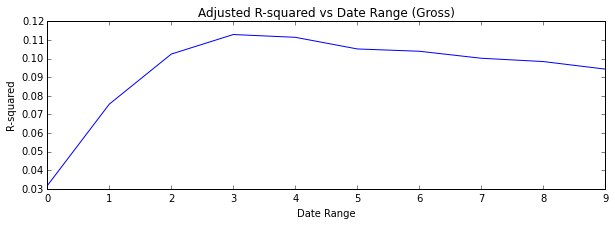

In [142]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_mean_gross ~ before_mean_gross + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
#plt.plot(range(1, 16), adj_r_sq)

plt.title('Adjusted R-squared vs Date Range (Gross)')
plt.ylabel('R-squared')
plt.xlabel('Date Range')  
plt.gcf()
plt.savefig('r squared gross.png')

In [102]:
adj_r_sq

[0.031725567146485445,
 0.075530610621354799,
 0.1024473896859518,
 0.11294400336644317,
 0.1114446519719442,
 0.1051885095284778,
 0.10395177916243981,
 0.10018980211592199,
 0.098409415334876349,
 0.0943432989968922]

### Model 4 observes the affect Nicolas Cage has on individuals before and after 1200 days (approx 3 years) 

In [103]:
y, X = dmatrices('after_mean_gross ~ before_mean_gross + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       after_mean_gross   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     1169.
Date:                Thu, 08 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:08:03   Log-Likelihood:            -3.6103e+05
No. Observations:               18903   AIC:                         7.221e+05
Df Residuals:                   18900   BIC:                         7.221e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          3.538e+07   5.07e+05     69.779      0.000      3.44e+07  3.64e+07
nc_movies[T.True] -7.005e+06   4.15e+06     -1.688      0.091     -1.51e+07  1.13e+06
before_mean_gross     0.3711      0.008     48.296      0.000         0.356     0.386
==============================================================================
Omnibus:                     8797.727   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            68715.059
Skew:                           2.083   Prob(JB):                         0.00
Kurtosis:                      11.360   Cond. No.                     7.88e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.88e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1180bd9d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x119706a50>]], dtype=object)

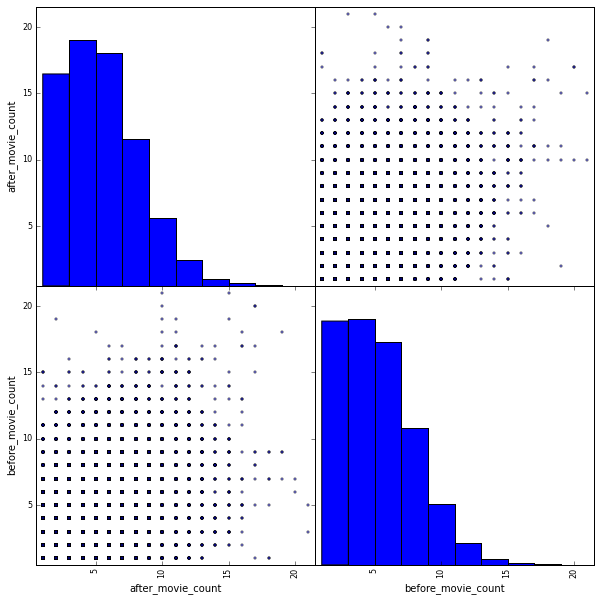

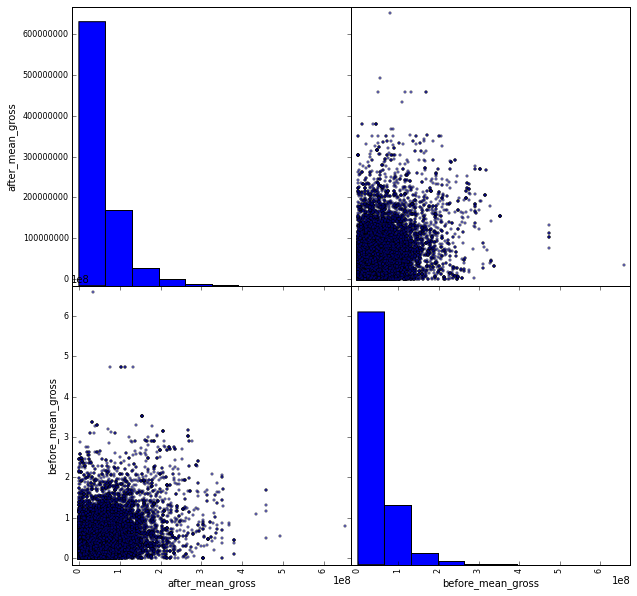

In [104]:
cols = ['after_movie_count', 'before_movie_count']
pd.scatter_matrix(all_models[4][cols], figsize=(10, 10))
cols = ['after_mean_gross', 'before_mean_gross']
pd.scatter_matrix(all_models[4][cols], figsize=(10, 10))

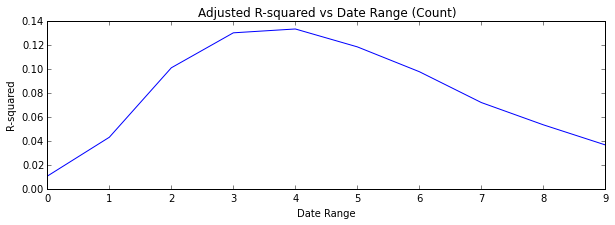

In [141]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_movie_count ~ before_movie_count + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
plt.title('Adjusted R-squared vs Date Range (Count)')
plt.ylabel('R-squared')
plt.xlabel('Date Range')  
plt.gcf()
plt.savefig('r squared count.png')

In [110]:
y, X = dmatrices('after_movie_count ~ before_movie_count + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_movie_count   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     1429.
Date:                Thu, 08 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:15:13   Log-Likelihood:                -45134.
No. Observations:               18903   AIC:                         9.027e+04
Df Residuals:                   18900   BIC:                         9.030e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.2083      0.037     85.847      0.000         3.135     3.282
nc_movies[T.True]      1.1220      0.230      4.886      0.000         0.672     1.572
before_movie_count     0.3628      0.007     52.885      0.000         0.349     0.376
==============================================================================
Omnibus:                     1686.716   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2325.329
Skew:                           0.735   Prob(JB):                         0.00
Kurtosis:                       3.890   Cond. No.                         66.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

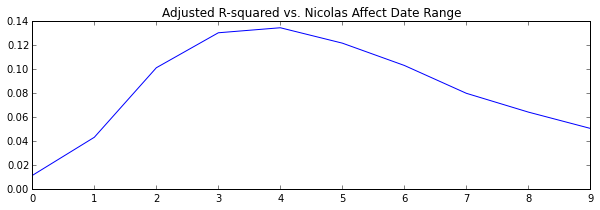

In [113]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_movie_count ~ before_movie_count + before_mean_gross + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
#plt.plot(range(1, 16), adj_r_sq)
plt.title('Adjusted R-squared vs. Nicolas Affect Date Range')

In [114]:
y, X = dmatrices('after_movie_count ~ before_movie_count + before_mean_gross + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_movie_count   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     960.4
Date:                Thu, 08 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:17:09   Log-Likelihood:                -45123.
No. Observations:               18903   AIC:                         9.025e+04
Df Residuals:                   18899   BIC:                         9.029e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.2932      0.042     79.006      0.000         3.212     3.375
nc_movies[T.True]      1.1052      0.230      4.815      0.000         0.655     1.555
before_movie_count     0.3646      0.007     53.091      0.000         0.351     0.378
before_mean_gross   -1.95e-09   4.25e-10     -4.589      0.000     -2.78e-09 -1.12e-09
==============================================================================
Omnibus:                     1677.395   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2311.463
Skew:                           0.732   Prob(JB):                         0.00
Kurtosis:                       3.890   Cond. No.                     7.89e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

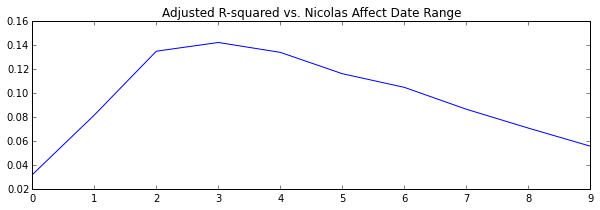

In [117]:
results = []
models = []
for frame in all_models:  #list of frames #originally labeled all_models
    y, X = dmatrices('after_total_gross ~ before_total_gross + nc_movies', data=frame, return_type='dataframe')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
    model = sm.OLS(y_train, X_train)
    models.append(model)
    results.append(model.fit())

len(results), len(models)
adj_r_sq = []

for i in range(len(results)):
    adj_r_sq.append(results[i].rsquared_adj)
plt.figure(figsize = (10, 3))
plt.plot(adj_r_sq)
#plt.plot(range(1, 16), adj_r_sq)
plt.title('Adjusted R-squared vs. Nicolas Affect Date Range')

In [118]:
y, X = dmatrices('after_total_gross ~ before_total_gross + nc_movies', data=all_models[3], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_total_gross   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     1469.
Date:                Thu, 08 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:20:37   Log-Likelihood:            -3.7559e+05
No. Observations:               18218   AIC:                         7.512e+05
Df Residuals:                   18215   BIC:                         7.512e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept           1.374e+08   2.21e+06     62.175      0.000      1.33e+08  1.42e+08
nc_movies[T.True]   5.013e+06    1.9e+07      0.264      0.792     -3.22e+07  4.23e+07
before_total_gross     0.4120      0.008     54.191      0.000         0.397     0.427
==============================================================================
Omnibus:                     7440.244   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            38387.102
Skew:                           1.929   Prob(JB):                         0.00
Kurtosis:                       8.974   Cond. No.                     3.42e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.42e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12147ca90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x121ad2510>]], dtype=object)

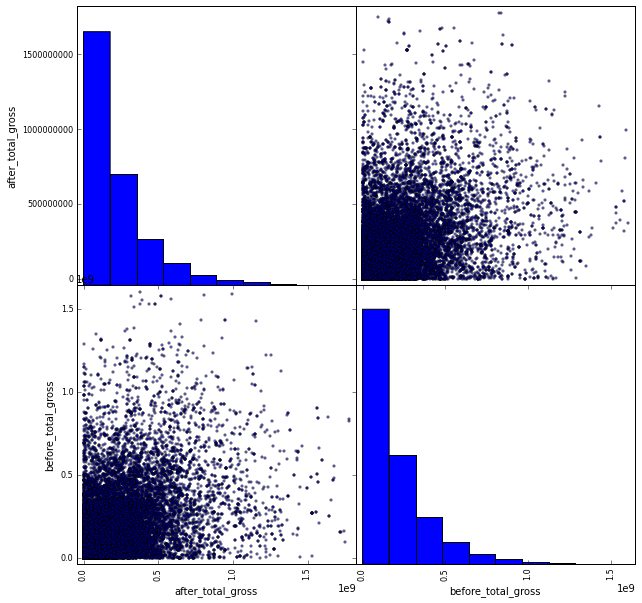

In [122]:
cols = ['after_total_gross', 'before_total_gross']
pd.scatter_matrix(all_models[3][cols], figsize=(10, 10))

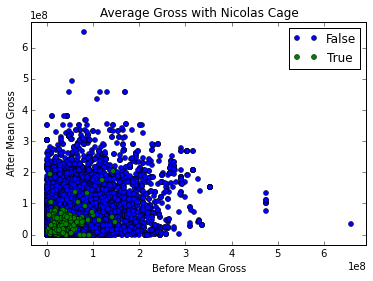

In [139]:
groups = all_models[4].groupby('nc_movies')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.before_mean_gross, group.after_mean_gross, marker='o', linestyle='', ms=5, label=name)
ax.legend()
plt.ylabel('After Mean Gross')
plt.xlabel('Before Mean Gross')
plt.title('Average Gross with Nicolas Cage')
plt.gcf()
plt.savefig('avg gross.png')
plt.show()


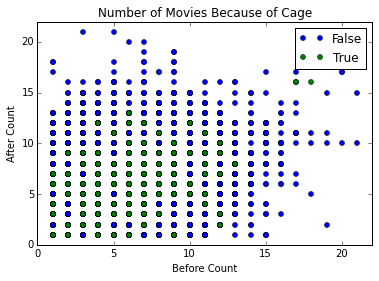

In [138]:
groups = all_models[4].groupby('nc_movies')

# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.before_movie_count, group.after_movie_count, marker='o', linestyle='', ms=5, label=name)
ax.legend()
plt.ylabel('After Count')
plt.xlabel('Before Count')
plt.title('Number of Movies Because of Cage')
plt.gcf()
plt.savefig('count.png')
plt.show()

In [143]:
y, X = dmatrices('after_movie_count ~ before_movie_count + before_mean_gross + nc_movies', data=all_models[4], return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = sm.OLS(y_train, X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      after_movie_count   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     960.4
Date:                Thu, 08 Oct 2015   Prob (F-statistic):               0.00
Time:                        22:48:05   Log-Likelihood:                -45123.
No. Observations:               18903   AIC:                         9.025e+04
Df Residuals:                   18899   BIC:                         9.029e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept              3.2932      0.042     79.006      0.000         3.212     3.375
nc_movies[T.True]      1.1052      0.230      4.815      0.000         0.655     1.555
before_movie_count     0.3646      0.007     53.091      0.000         0.351     0.378
before_mean_gross   -1.95e-09   4.25e-10     -4.589      0.000     -2.78e-09 -1.12e-09
==============================================================================
Omnibus:                     1677.395   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2311.463
Skew:                           0.732   Prob(JB):                         0.00
Kurtosis:                       3.890   Cond. No.                     7.89e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.89e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [146]:
predicts = results.predict(X_test)
predicts

array([ 3.8787632 ,  4.38302387,  5.6773094 , ...,  5.41926931,
        4.01012507,  3.95361955])

In [150]:
mse = mean_squared_error(y_test, predicts)

In [151]:
mse

6.8752544638342332